In [ ]:
# import libraries
from sklearn.datasets import fetch_lfw_pairs # this is the dataset we are going to use
from sklearn.model_selection import train_test_split # this is the function we are going to use to split the data
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# loading the data
train = fetch_lfw_pairs(subset="train")
test = fetch_lfw_pairs(subset="test")
classes = list(train.target_names) # the classes are the names of the people in the dataset

X = train.pairs
X = X.astype("float32") # we need to convert the data to float32 in order to be able to use it in the model and to be able to plot it
y = train.target.astype("float32") # the .target attribute contains the labels of the data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_test = test.pairs
X_test = X_test.astype("float32")
y_test = test.target.astype("float32")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42) # we split the data into training and validation data

X_train.shape

(1474, 2, 62, 47)

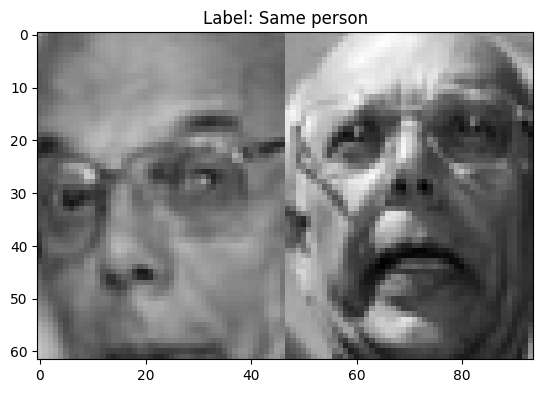

In [ ]:
plt.imshow(np.concatenate([X_train[100][0], X_train[100][1]], axis=1), cmap='gray') # we plot the first image in each pair to see how the data looks like
plt.title("Label: {}".format(classes[int(y_train[100])])) # we also print the label of the pair
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_SHAPE = (X_train.shape[2], X_train.shape[3], 1) # the shape of the images in the dataset

# we initialize the augmented data with the first 100 images of the first and second person in each pair
augmented_X_train_1 = X_train[:100, 0]
augmented_X_train_2 = X_train[:100, 1]
augmented_y_train = y_train[:100] # we initialize the augmented labels with the first 100 labels

datagen = ImageDataGenerator(zoom_range=[0.6, 0.5], horizontal_flip=True) # we define the augmentation techniques we are going to use, which are zooming and flipping the images
# IMG_SHAPE[0], IMG_SHAPE[1] can be used instead of *IMG_SHAPE to get the same result of reshaping
datagen.fit(augmented_X_train_1.reshape(augmented_X_train_1.shape[0], *IMG_SHAPE[:2], 1))
datagen.fit(augmented_X_train_2.reshape(augmented_X_train_2.shape[0], *IMG_SHAPE[:2], 1))
# we create a data generator for the first and second person in each pair
data_generator_1 = datagen.flow(augmented_X_train_1.reshape(augmented_X_train_1.shape[0], *IMG_SHAPE[:2], 1), shuffle=False, batch_size=1)
data_generator_2 = datagen.flow(augmented_X_train_2.reshape(augmented_X_train_2.shape[0], *IMG_SHAPE[:2], 1), shuffle=False, batch_size=1)
# generate the augmented data for the first and second person in each pair
X_train_aug_1 = np.asarray([data_generator_1.next() for x in range(100)]).reshape(100, *IMG_SHAPE[:2])
X_train_aug_2 = np.asarray([data_generator_2.next() for x in range(100)]).reshape(100, *IMG_SHAPE[:2])
# concatenate the augmented data for the first and second person in each pair to get the final augmented data
augmented_X_train = np.array([X_train_aug_1, X_train_aug_2])
arr = np.transpose(augmented_X_train, (1, 0, 2, 3)) # we transpose the data to get the final shape, transposing = swapping the axes

augmented_X_train = arr.reshape(100, 2, *IMG_SHAPE[:2]) # we reshape the data to get the final shape

In [ ]:
# Concatenate the augmented data with the original training data
X_train = np.concatenate([X_train, augmented_X_train])
y_train = np.concatenate([y_train, augmented_y_train])

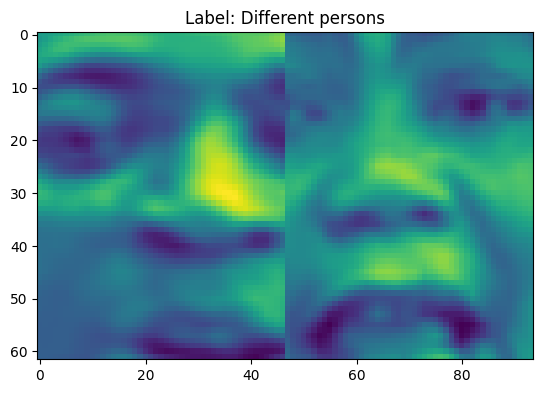

In [ ]:
# plotting a sample of the augmented images to see how they look like
plt.imshow(np.concatenate([augmented_X_train[55][0], augmented_X_train[55][1]], axis=1))
plt.title("Label: {}".format(classes[int(y_train[55])]))
plt.show()

In [ ]:
# we normalize the data to be between 0 and 1
X_train /= 255
X_val /= 255
X_test /= 255

In [ ]:
# we split the data into the first and second person in each pair to be able to use them in the model
img1_train = X_train[:, 0]
img2_train = X_train[:, 1]

img1_val = X_val[:, 0]
img2_val = X_val[:, 1]

img1_test = X_test[:, 0]
img2_test = X_test[:, 1]

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from keras.regularizers import l2

IMG_SHAPE = (X_train.shape[2], X_train.shape[3], 1) # Shape of the images

# defining the model, we are going to use a siamese network with a CNN base, as we are trying to compare the similarity between two images
# we are going to use the contrastive loss function to train the model as it aims to minimize the distance between similar images and maximize the distance between dissimilar images
fine_tunning = False
def get_cnn_model():
  model = models.Sequential(name="CNN")
  for i in range(len([32, 64, 128])): # 32 filters for the first layer, 64 for the second, and 128 for the third
    if i == 0:
      # First layer with input shape, and kernel regularizer to prevent overfitting
      model.add(layers.Conv2D([32, 64, 128][i], (3, 3), input_shape=IMG_SHAPE, activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
    else:
      # Add more convolutional layers
      model.add(layers.Conv2D([32, 64, 128][i], (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
      model.add(layers.Conv2D([32, 64, 128][i], (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
      model.add(layers.Conv2D([32, 64, 128][i], (5, 5), activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
    model.add(layers.BatchNormalization()) # Normalize the activations of the previous layer at each batch in order to reduce overfitting
    model.add(layers.MaxPooling2D()) # Pooling layer to reduce the spatial dimensions of the output volume
    model.add(layers.Dropout(0.3)) # Dropout layer to prevent overfitting
  # global average pooling is different from max pooling as it computes the average output of each feature map in the previous layer, while max pooling computes the maximum output
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(128, activation="relu", kernel_regularizer=l2(1e-4))) # a dense(1) layer isn't used as we are going to use the contrastive loss function
  return model
# Define the input layers for the two images to be compared
input_a = layers.Input(shape=IMG_SHAPE)
input_b = layers.Input(shape=IMG_SHAPE)

if fine_tunning is False: # if we are not going to fine-tune the model, we are going to use the contrastive loss function
  cnn_model = get_cnn_model()
  processed_a = cnn_model(input_a)
  processed_b = cnn_model(input_b)

  # Use contrastive loss
  def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(0.0, margin - y_pred)))

  distance = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
  prediction = layers.Dense(1, activation='sigmoid')(distance)
  model = models.Model([input_a, input_b], prediction)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=contrastive_loss, metrics=["accuracy"])
else: # if we are going to fine-tune the model, we are going to use the binary crossentropy loss function onto the pre-trained model
  # Use pre-trained InceptionResNetV2 with residual connections
  base_model = InceptionResNetV2(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
  for layer in base_model.layers:
    layer.trainable = False

  processed_a = base_model(input_a)
  processed_b = base_model(input_b)

  # Add residual connections, in order to prevent the vanishing gradient problem, to help the model to learn better
  shortcut_a = layers.Conv2D(128, (1, 1), activation='relu')(processed_a)
  shortcut_b = layers.Conv2D(128, (1, 1), activation='relu')(processed_b)

  processed_a = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(processed_a)
  processed_a = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(processed_a)
  processed_a = layers.Add()([processed_a, shortcut_a]) # Add the shortcut to the processed output to get the final output

  processed_b = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(processed_b)
  processed_b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(processed_b)
  processed_b = layers.Add()([processed_b, shortcut_b])

  # Global average pooling and dense layers
  flatten_a = layers.GlobalAveragePooling2D()(processed_a)
  flatten_b = layers.GlobalAveragePooling2D()(processed_b)
  # Normalize the output of the global average pooling layer to have a unit norm
  normalized_a = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(flatten_a)
  normalized_b = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(flatten_b)

  # Cosine similarity for comparison between the two images
  def cosine_similarity(tensors):
    # Cosine similarity = dot product of the two vectors divided by the product of the magnitudes of the two vectors
    return K.dot(tensors[0], tensors[1]) / (K.sqrt(K.sum(K.square(tensors[0]), axis=-1)) * K.sqrt(K.sum(K.square(tensors[1]), axis=-1)))

  similarity = layers.Lambda(cosine_similarity)([normalized_a, normalized_b])
  prediction = layers.Dense(1, activation='sigmoid')(similarity) # Dense layer with sigmoid activation function to get the final output of the model
  model = models.Model([input_a, input_b], prediction) # Define the model with the input layers and the output layer

  # Early stopping and model checkpoint callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Stop training the model if the validation loss doesn't improve for 3 epochs
# Save the best model based on the validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='siamese_model.hdf5',
    save_best_only=True,
    monitor='val_loss',
    mode='min')
# defining the optimizer, loss and the metrics of the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])


In [ ]:
# Train the model
sn = model.fit([X_train[:, 0], X_train[:, 1]], y_train, validation_data=([X_val[:, 0], X_val[:, 1]], y_val), batch_size=40, epochs=200, callbacks=[early_stopping])

Epoch 1/200
40/40 [==============================] - 17s 73ms/step - loss: 5.5281 - accuracy: 0.5267 - val_loss: 5.1906 - val_accuracy: 0.5234
Epoch 2/200
40/40 [==============================] - 2s 40ms/step - loss: 4.8975 - accuracy: 0.5343 - val_loss: 4.5973 - val_accuracy: 0.5234
Epoch 3/200
40/40 [==============================] - 2s 42ms/step - loss: 4.3320 - accuracy: 0.5241 - val_loss: 4.0756 - val_accuracy: 0.5248
Epoch 4/200
40/40 [==============================] - 2s 38ms/step - loss: 3.8429 - accuracy: 0.5432 - val_loss: 3.6278 - val_accuracy: 0.5730
Epoch 5/200
40/40 [==============================] - 1s 37ms/step - loss: 3.4301 - accuracy: 0.5381 - val_loss: 3.2466 - val_accuracy: 0.5771
Epoch 6/200
40/40 [==============================] - 2s 41ms/step - loss: 3.0800 - accuracy: 0.5324 - val_loss: 2.9225 - val_accuracy: 0.5882
Epoch 7/200
40/40 [==============================] - 1s 36ms/step - loss: 2.7750 - accuracy: 0.5457 - val_loss: 2.6457 - val_accuracy: 0.5331
Epoch

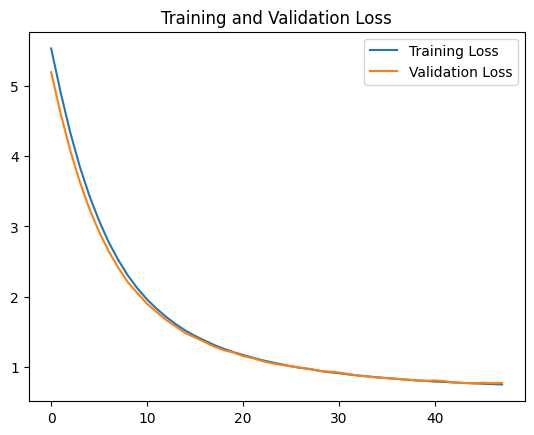

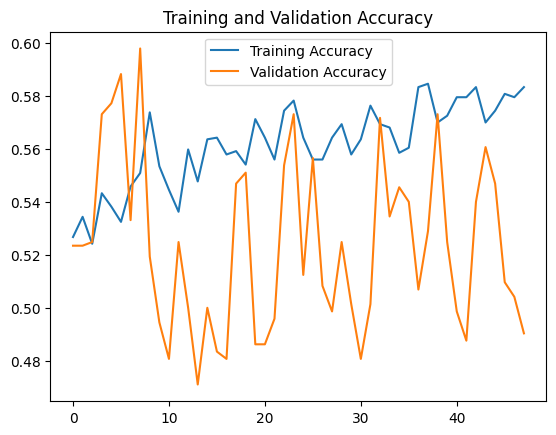

In [ ]:
# view the history of the model through the epochs
train_loss = sn.history['loss']
val_loss = sn.history['val_loss']
train_acc = sn.history['accuracy']
val_acc = sn.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate([X_test[:, 0], X_test[:, 1]],y_test, batch_size=40)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

25/25 [==============================] - 0s 11ms/step - loss: 0.7735 - accuracy: 0.5010
Test Loss: 0.7734721899032593
Test Accuracy: 0.5009999871253967


In [ ]:
# Fine-tuning the model
fine_tuning = True
sn2 = model.fit([X_train[:, 0], X_train[:, 1]], y_train, validation_data=([X_val[:, 0], X_val[:, 1]], y_val), batch_size=24, epochs=100, callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/100
66/66 [==============================] - 3s 29ms/step - loss: 0.7520 - accuracy: 0.5680 - val_loss: 0.7523 - val_accuracy: 0.5730
Epoch 2/100
 4/66 [>.............................] - ETA: 1s - loss: 0.7453 - accuracy: 0.6146

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 2s 36ms/step - loss: 0.7487 - accuracy: 0.5610 - val_loss: 0.7459 - val_accuracy: 0.5799
Epoch 3/100
66/66 [==============================] - 2s 38ms/step - loss: 0.7394 - accuracy: 0.5553 - val_loss: 0.7438 - val_accuracy: 0.5179
Epoch 4/100
66/66 [==============================] - 2s 29ms/step - loss: 0.7313 - accuracy: 0.5584 - val_loss: 0.7328 - val_accuracy: 0.5606
Epoch 5/100
66/66 [==============================] - 2s 26ms/step - loss: 0.7281 - accuracy: 0.5680 - val_loss: 0.7313 - val_accuracy: 0.5744
Epoch 6/100
66/66 [==============================] - 2s 26ms/step - loss: 0.7236 - accuracy: 0.5610 - val_loss: 0.7289 - val_accuracy: 0.5468
Epoch 7/100
66/66 [==============================] - 2s 26ms/step - loss: 0.7195 - accuracy: 0.5610 - val_loss: 0.7247 - val_accuracy: 0.5661
Epoch 8/100
66/66 [==============================] - 2s 27ms/step - loss: 0.7179 - accuracy: 0.5731 - val_loss: 0.7234 - val_accuracy: 0.5565
Epoch 9/100
66/66 

In [ ]:
# evaluate the model on the test data after fine-tuning
test_loss, test_acc = model.evaluate([X_test[:, 0], X_test[:, 1]],y_test, batch_size=40)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

25/25 [==============================] - 0s 12ms/step - loss: 0.6955 - accuracy: 0.5440
Test Loss: 0.6954809427261353
Test Accuracy: 0.5440000295639038


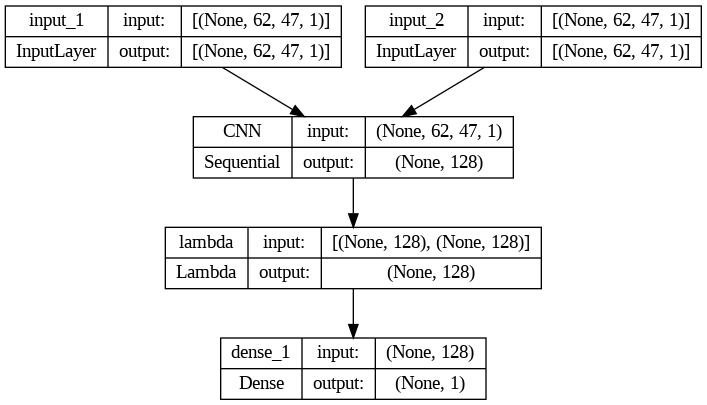

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

(4000, 1868)
(223, 223)
(62, 47)
(1599, 899)
(462, 462)
(62, 47)
(1152, 648)
(185, 186)
(62, 47)
(1599, 899)
(385, 385)
(62, 47)
Shape of pairs before reshape: (2, 2, 62, 47)
2


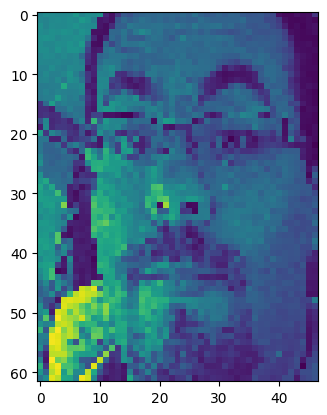

In [ ]:
# testing the model on custom images of my friends
import cv2
import os
import numpy as np
import dlib
# Load images from a folder perform face detection and extract the face region
def load_images_from_folder(folder, target_shape=(47,62)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        # Convert image to grayscale (optional for dlib)
        # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Face detection using dlib
        detector = dlib.get_frontal_face_detector()
        rects = detector(img, 1)
        print(img.shape)
        # Process detected faces
        for rect in rects:
            x1, y1, x2, y2 = rect.left(), rect.top(), rect.right(), rect.bottom()
            # Extract face region and resize
            face_img = img[y1:y2, x1:x2]
            print(face_img.shape)
            face_img = cv2.resize(face_img, target_shape)
            print(face_img.shape)
            images.append(face_img)
    return images

images = load_images_from_folder("/content/drive/MyDrive/ColabNotebooks/Hema")
plt.imshow(images[1])
#print(images[1].shape)
def get_image_pairs(images): # function to get the pairs of images to be compared
    pairs = []
    for i in range(0,len(images),2):
            pairs.append([images[i], images[i+1]])
    return np.array(pairs)



pairs = get_image_pairs(images)
print(f"Shape of pairs before reshape: {pairs.shape}")
# reshape (2, 2, 62, 47, 1) to (2, 2, 47, 62, 1) to match the shape of the model input
pairs = pairs.reshape(2, 2, 62, 47, 1)
print(pairs.shape[0])

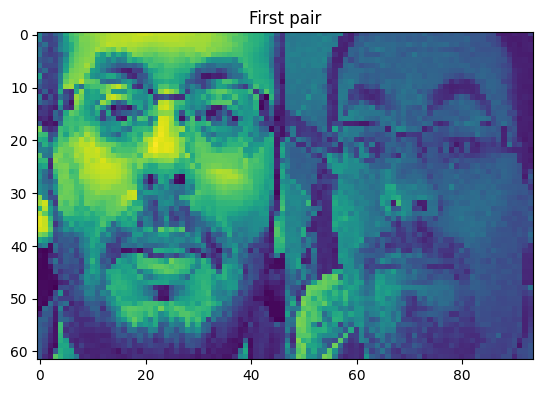

In [ ]:
plt.imshow(np.concatenate([pairs[0][0], pairs[0][1]], axis=1))
plt.title("First pair")
plt.show()

In [ ]:
# predict the similarity between the pair of images
predictions = model.predict([pairs[:, 0], pairs[:, 1]])
print("Prediction: {}".format(predictions[1][0]))
print("")

if predictions[1][0] > 0.5:
    print("Same Person")
else:
    print("Not The Same Person")

# save the model
model.save("face_recognition_model.h5")

1/1 [==============================] - 0s 74ms/step
Prediction: 0.7924757599830627

Same Person


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 62, 47, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 62, 47, 1)]          0         []                            
                                                                                                  
 CNN (Sequential)            (None, 128)                  724864    ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128)                  0         ['CNN[0][0]',             

In [ ]:
# load a new person's images
images2 = load_images_from_folder("/content/drive/MyDrive/ColabNotebooks/Lulu")

(1599, 899)
(321, 321)
(62, 47)
(1280, 510)
(321, 321)
(62, 47)
(1599, 899)
(666, 666)
(62, 47)
(1160, 868)
(90, 90)
(62, 47)


In [ ]:
# get the new pairs of images to be compared
pairs2 = get_image_pairs(images2)
print(f"Shape of pairs before reshape: {pairs2.shape}")

pairs2 = pairs2.reshape(2, 2, 62, 47, 1)

Shape of pairs before reshape: (2, 2, 62, 47)


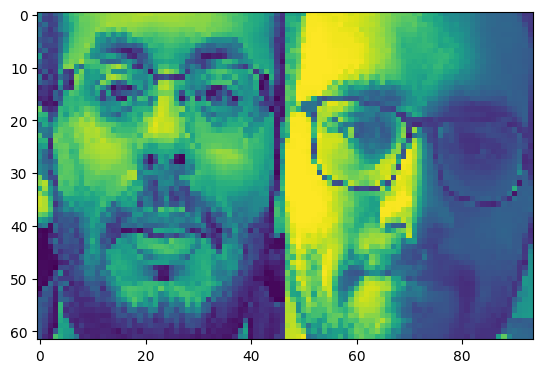

In [ ]:
# show the pair
plt.imshow(np.concatenate([pairs[0][0], pairs2[0][0]], axis=1))

In [ ]:
# predict the similarity between the images from the new and the old pair
predictions = model.predict([pairs[:, 0], pairs2[:, 0]])
print("Prediction: {}".format(predictions[0][0]))
print("")

if predictions[0][0] > 0.5:
    print("Same Person")
else:
    print("Not The Same Person")

1/1 [==============================] - 0s 41ms/step
Prediction: 0.0025618646759539843

Not The Same Person


In [ ]:
#export as html
!jupyter nbconvert --to html Face_Recognition.ipynb